# 개체명 인식의 BIO 표현 이해하기

## 개체명 인식 데이터 전처리하기

In [1]:
import urllib.request
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x7fc4132868b0>)

In [3]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [4]:
print("전체 샘플 개수: ", len(tagged_sentences))
print('첫번째 샘플 :',tagged_sentences[0])

전체 샘플 개수:  14041
첫번째 샘플 : [['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 

즉, `[('eu', 'B-ORG'), ('rejects', 'O')]`와 같은 문장 샘플이 있다면 eu와 rejects는 같이 저장하고, B-ORG와 O를 같이 저장할 필요가 있습니다. 

이 경우 파이썬 함수 중에서 `zip()`함수가 유용한 역할을 합니다. `zip()`함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다.

In [5]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 ner_tags에 저장하였습니다. 임의로 첫번째 샘플을 출력해보겠습니다.

In [6]:
print('첫번째 샘플의 문장 :',sentences[0])
print('첫번째 샘플의 레이블 :',ner_tags[0])

첫번째 샘플의 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
첫번째 샘플의 레이블 : ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서만 `sentences[0]`에 저장되었으며 개체명에 대해서만 `ner_tags[0]`에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, `sentences`는 예측을 위한 `X`에 해당되며 `ner_tags`는 예측 대상인 `y`에 해당됩니다. 다른 샘플들도 확인하기 위해 임의로 12번 인덱스 샘플에 대해서도 확인해보겠습니다.

In [7]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


단어에 대해서만 `sentences[12]`에, 또한 개체명에 대해서만 `ner_tags[12]`에 저장되었습니다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있습니다. 사실 14,041개의 문장 샘플의 길이는 전부 제각각입니다. 전체 데이터의 길이 분포를 확인해봅시다.

샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


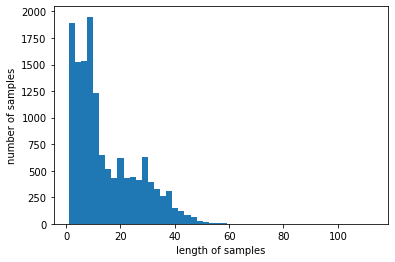

In [8]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 샘플들의 길이가 대체적으로 0\~40의 길이를 가지며, 특히 0\~20의 길이를 가진 샘플이 상당한 비율을 차지하는 것을 보여줍니다. 길이가 가장 긴 샘플의 길이는 113입니다. 

케라스 토크나이저를 통해서 정수 인코딩을 진행합니다. 이번에는 문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4,000개의 단어만을 사용합니다.

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [9]:
vocab_size = 4000
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [10]:
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


정수 인코딩을 수행합니다.

In [11]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

문장 데이터에 대해서 정수 인코딩이 수행된 결과는 `X_train`, 개체명 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 `y_train`에 저장되었습니다.

정수 인코딩이 되었는지 확인을 위해 임의로 첫번째 샘플을 출력해보겠습니다.

In [12]:
print('첫번째 샘플의 문장 :',X_train[0])
print('첫번째 샘플의 레이블 :',y_train[0])

첫번째 샘플의 문장 : [989, 1, 205, 629, 7, 3939, 216, 1, 3]
첫번째 샘플의 레이블 : [4, 1, 7, 1, 1, 1, 7, 1, 1]


현재 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체된 상황입니다. 이를 확인하기 위해 디코딩 작업을 진행해봅시다. 이를 위해 정수로부터 단어로 변환하는 `index_to_word`를 만듭니다.

In [13]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

정수 인코딩 된 첫번째 문장을 다시 디코딩해보겠습니다.

In [14]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
    decoded.append(index_to_word[index]) # 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


일부 단어가 'OOV'로 대체되었습니다. 앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 70 이내입니다. `X`에 해당되는 데이터 `X_train`의 샘플들과 `y`에 해당되는 데이터 `y_train` 샘플들의 모든 길이를 임의로 70정도로 맞추어 보겠습니다. 패딩을 진행합니다.

In [15]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

모든 샘플의 길이가 70이 되었습니다. 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리합니다.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행합니다.

In [17]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

각 데이터에 대한 크기(shape)를 확인해보겠습니다.

In [18]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


## 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

하이퍼파라미터인 임베딩 벡터의 차원은 128, 은닉 상태의 크기는 128입니다. 모델은 다 대 다 구조의 LSTM을 사용합니다. 이 경우 LSTM의 `return_sequences`의 인자값은 `True`로 주어야만 합니다. 이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 `Embedding()`에 `mask_zero=True`를 설정하여 숫자 0은 연산에서 제외시킨다는 옵션을 줄 수 있습니다. 출력층에 `TimeDistributed()`를 사용했는데, `TimeDistributed()`는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용합니다.

해당 모델은 모든 시점에 대해서 개체명 레이블 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 128이며, 8 에포크를 수행합니다. `validation_data`로 테스트 데이터를 선택하여 학습하는 동안 테스트 데이터에 대한 정확도를 확인합니다.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam
import numpy as np

In [20]:
embedding_dim = 128
hidden_units = 128

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 79s 753ms/step - loss: 0.2007 - accuracy: 0.8235 - val_loss: 0.1354 - val_accuracy: 0.8332
Epoch 2/8
88/88 [==============================] - 63s 713ms/step - loss: 0.1090 - accuracy: 0.8463 - val_loss: 0.0841 - val_accuracy: 0.8754
Epoch 3/8
88/88 [==============================] - 70s 793ms/step - loss: 0.0719 - accuracy: 0.8993 - val_loss: 0.0572 - val_accuracy: 0.9205
Epoch 4/8
88/88 [==============================] - 60s 688ms/step - loss: 0.0484 - accuracy: 0.9324 - val_loss: 0.0426 - val_accuracy: 0.9407
Epoch 5/8
88/88 [==============================] - 62s 699ms/step - loss: 0.0372 - accuracy: 0.9476 - val_loss: 0.0369 - val_accuracy: 0.9480
Epoch 6/8
88/88 [==============================] - 62s 708ms/step - loss: 0.0310 - accuracy: 0.9561 - val_loss: 0.0343 - val_accuracy: 0.9521
Epoch 7/8
88/88 [==============================] - 61s 689ms/step - loss: 0.0270 - accuracy: 0.9616 - val_loss: 0.0327 - val_accuracy: 0.9543
Epoch 

In [22]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 8s 91ms/step - loss: 0.0325 - accuracy: 0.9533

 테스트 정확도: 0.9533


In [23]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([X_test[i]]))

# 확률 벡터를 정수 레이블로 변경.
y_predicted = np.argmax(y_predicted, axis=-1)

# 원-핫 벡터를 정수 인코딩으로 변경.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

1/1 [==============================] - 3s 3s/step
단어             |실제값  |예측값
-----------------------------------
northern         : B-ORG   B-ORG
states           : I-ORG   B-ORG
power            : I-ORG   B-ORG
co               : I-ORG   I-ORG
sets             : O       O
OOV              : O       O
.                : O       O
